## BERT-Base

In [27]:
bert_model=TFBertModel.from_pretrained('bert-base-uncased')
bert_tokenizer=BertTokenizer.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [28]:
def text_encoding(tokenizer, texts, max_length, batch_size=256):
    
    input_ids = []
    attention_mask = []
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        inputs = tokenizer.batch_encode_plus(batch,
                                             max_length=max_len, padding='max_length',
                                             truncation=True, return_attention_mask=True,
                                             return_token_type_ids=False)
        input_ids.extend(inputs['input_ids'])
        attention_mask.extend(inputs['attention_mask'])        
    
    
    return tf.convert_to_tensor(input_ids), tf.convert_to_tensor(attention_mask)

In [29]:
max_len = 64
X_train_ids, X_train_attention = text_encoding(bert_tokenizer, X_train.tolist(),max_len)
X_val_ids, X_val_attention = text_encoding(bert_tokenizer, X_val.tolist(), max_len)
X_test_ids, X_test_attention = text_encoding(bert_tokenizer, X_test.tolist(), max_len)

In [31]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

In [32]:
def model_architecture():
    # Model architecture

    weight_initializer = tf.keras.initializers.GlorotNormal(seed=42)

    # DistilBERT Layers
    input_ids_layer = Input(shape=(max_len,), name='input_ids', dtype='int32')
    input_attention_layer = Input(shape=(max_len,), name='input_attention', dtype='int32')
    last_hidden_state = bert_model(input_ids_layer,input_attention_layer)[1]
#     cls_token = last_hidden_state[:, 0, :]

    # NN layer
    X = Dropout(0.2)(last_hidden_state)
    X = Dense(128, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(64, activation='relu')(X)
    X = Dropout(0.1)(X)
    X = Dense(16, activation='relu')(X)
    
    output = Dense(1,activation='sigmoid',kernel_initializer=weight_initializer)(X)

    model_bert = Model(inputs=[input_ids_layer, input_attention_layer], outputs=output)
    
    return model_bert

In [33]:
model_bert=model_architecture()
model_bert.layers[2].trainable=True

In [34]:
model_bert.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_attention (InputLayer)    [(None, 64)]         0                                            
__________________________________________________________________________________________________
tf_bert_model_1 (TFBertModel)   TFBaseModelOutputWit 109482240   input_ids[0][0]                  
                                                                 input_attention[0][0]            
__________________________________________________________________________________________________
dropout_77 (Dropout)            (None, 768)          0           tf_bert_model_1[0][1]      

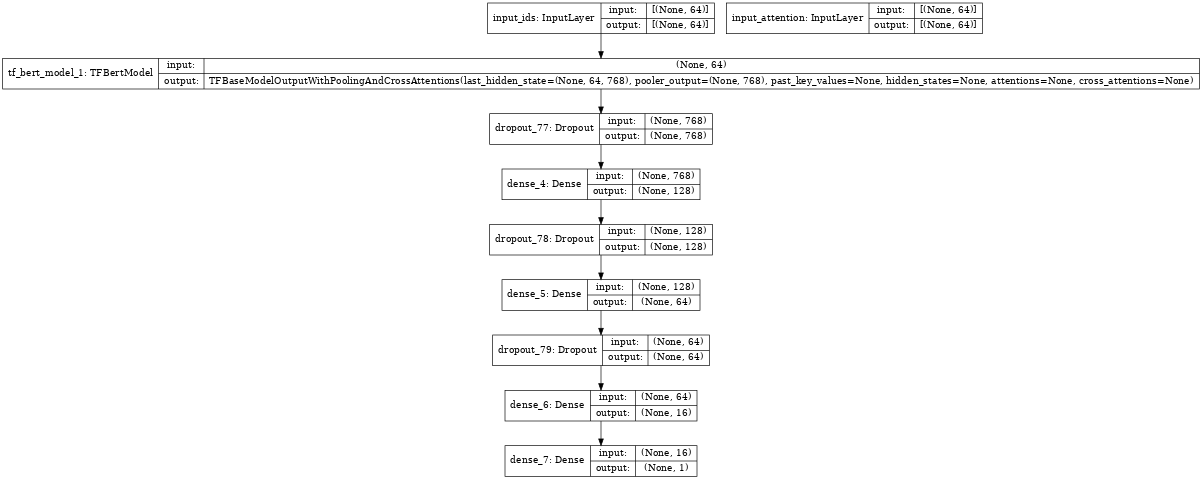

In [35]:
tf.keras.utils.plot_model(model_bert, show_shapes=True, dpi=48)

In [36]:
optimizer= tf.keras.optimizers.Adam(lr = 5e-6 , epsilon = 1e-8 , decay  = 0.01 , clipnorm = 1.0)

In [37]:
model_bert.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [38]:
Epochs=20
Batch_size=128

model_bert_results = model_bert.fit(
    x = [X_train_ids, X_train_attention],
    y = y_train,
    epochs = Epochs,
    batch_size = Batch_size,
    validation_data = ([X_val_ids, X_val_attention], y_val), callbacks=[callback])



Epoch 1/20
48/48 [==============================] - 71s 1s/step - loss: 0.6681 - accuracy: 0.6071 - val_loss: 0.6362 - val_accuracy: 0.7026
Epoch 2/20
48/48 [==============================] - 45s 937ms/step - loss: 0.6149 - accuracy: 0.7103 - val_loss: 0.5669 - val_accuracy: 0.7800
Epoch 3/20
48/48 [==============================] - 45s 939ms/step - loss: 0.5541 - accuracy: 0.7791 - val_loss: 0.5181 - val_accuracy: 0.7958
Epoch 4/20
48/48 [==============================] - 45s 939ms/step - loss: 0.5089 - accuracy: 0.8115 - val_loss: 0.4816 - val_accuracy: 0.8155
Epoch 5/20
48/48 [==============================] - 45s 939ms/step - loss: 0.4814 - accuracy: 0.8192 - val_loss: 0.4661 - val_accuracy: 0.8201
Epoch 6/20
48/48 [==============================] - 45s 938ms/step - loss: 0.4648 - accuracy: 0.8238 - val_loss: 0.4517 - val_accuracy: 0.8221
Epoch 7/20
48/48 [==============================] - 45s 939ms/step - loss: 0.4462 - accuracy: 0.8355 - val_loss: 0.4459 - val_accuracy: 0.8234
Ep

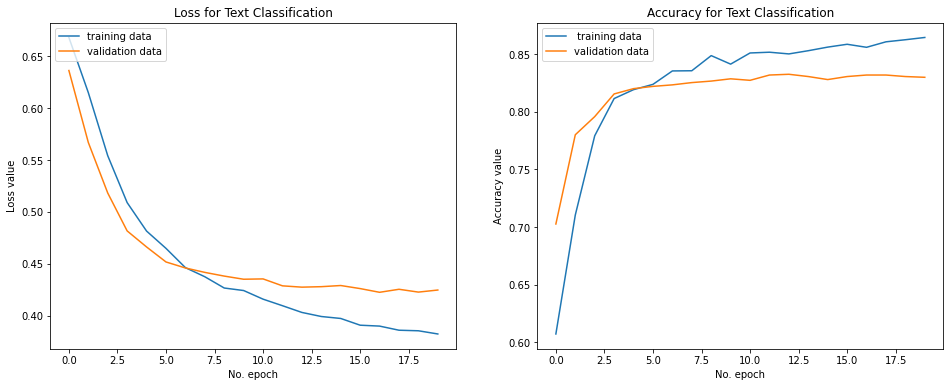

In [39]:
plt.figure(figsize=(16,6))

## Loss vs Epochs for train and validation data
plt.subplot(1,2,1)
plt.plot(model_bert_results.history['loss'], label='training data')
plt.plot(model_bert_results.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")

## Accuracy vs Epochs for train and validation data
plt.subplot(1,2,2)
plt.plot(model_bert_results.history['accuracy'], label=' training data')
plt.plot(model_bert_results.history['val_accuracy'], label='validation data')
plt.title('Accuracy for Text Classification')
plt.ylabel('Accuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [46]:
import seaborn as sns
from sklearn.metrics import f1_score

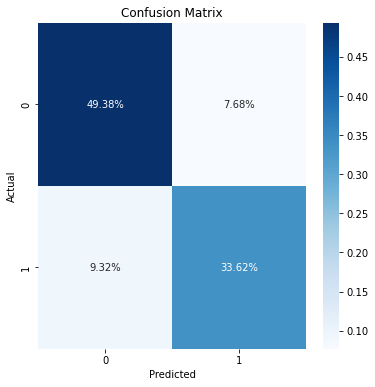


+-----------------------+--------+
|        Metrics        | Values |
+-----------------------+--------+
|     Specificity(%)    | 86.54  |
| Sensitivity/Recall(%) | 78.29  |
|      Precision(%)     |  81.4  |
|     Micro F1 Score    |  0.83  |
+-----------------------+--------+


In [47]:
performance_evaluation(model_bert,[X_val_ids, X_val_attention],y_val)